In [69]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import pickle
from tqdm import tqdm
import rdflib
from rdflib import Graph
from rdflib.namespace import BRICK
import warnings
from scipy import stats

In [70]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [71]:
filename_ttl='datasets/bts_site_b_train/Site_B.ttl'

g = Graph().parse(filename_ttl)

In [72]:
filename_ttl='datasets/bts_site_b_train/Site_B.ttl'

g = Graph().parse(filename_ttl)

# Define the SPARQL query to retrieve electrical energy sensors ordered by meters
query_energy = """
SELECT ?meter ?sensor ?stream_id ?phase_count ?phases ?unit ?power_complexity ?power_flow
WHERE {
    ?sensor rdf:type brick:Electrical_Energy_Sensor .
    ?meter rdf:type brick:Electrical_Meter .
    ?sensor brick:isPointOf ?meter .
    ?sensor senaps:stream_id ?stream_id .
    OPTIONAL { ?sensor brick:electricalPhaseCount [ brick:value ?phase_count ] . }
    OPTIONAL { ?sensor brick:electricalPhases [ brick:value ?phases ] . }
    OPTIONAL { ?sensor brick:hasUnit [ brick:value ?unit ] . }
    OPTIONAL { ?sensor brick:powerComplexity [ brick:value ?power_complexity ] . }
    OPTIONAL { ?sensor brick:powerFlow [ brick:value ?power_flow ] . }
}
ORDER BY ?meter
"""

# Run the query
results_energy = g.query(query_energy)

# Prepare the data for the DataFrame
data_energy = []
for row in results_energy:
    data_energy.append({
        'Meter': str(row['meter']),
        'Sensor': str(row['sensor']),
        'Stream ID': str(row['stream_id']),
        'Phase Count': str(row['phase_count']) if row['phase_count'] else None,
        'Phases': str(row['phases']) if row['phases'] else None,
        'Unit': str(row['unit']) if row['unit'] else None,
        'Power Complexity': str(row['power_complexity']) if row['power_complexity'] else None,
        'Power Flow': str(row['power_flow']) if row['power_flow'] else None
    })

# Create a DataFrame from the results
df_energy_meters = pd.DataFrame(data_energy)

# Display the DataFrame
# df_energy_meters.head()
display(df_energy_meters.head())

,Meter,Sensor,Stream ID,Phase Count,Phases,Unit,Power Complexity,Power Flow
0,dch:org/df125f8d_93e4_4a4f_bc87_1c4e332f32b8/s...,dch:org/df125f8d_93e4_4a4f_bc87_1c4e332f32b8/s...,52333345_fda6_498a_a5eb_8c9becf3996b,3,ABC,KiloV-A_Reactive,reactive,net
1,dch:org/df125f8d_93e4_4a4f_bc87_1c4e332f32b8/s...,dch:org/df125f8d_93e4_4a4f_bc87_1c4e332f32b8/s...,9ff52a4f_128b_4c44_86b3_4fa1d029506e,3,ABC,KiloW-HR,real,net
2,dch:org/df125f8d_93e4_4a4f_bc87_1c4e332f32b8/s...,dch:org/df125f8d_93e4_4a4f_bc87_1c4e332f32b8/s...,40697530_1df5_47dd_ae18_89c4aaa2a8fd,3,ABC,KiloW-HR,real,net
3,dch:org/df125f8d_93e4_4a4f_bc87_1c4e332f32b8/s...,dch:org/df125f8d_93e4_4a4f_bc87_1c4e332f32b8/s...,1afde7d7_004d_41c5_89b2_ede5967e4807,3,ABC,KiloV-A_Reactive,reactive,net
4,dch:org/df125f8d_93e4_4a4f_bc87_1c4e332f32b8/s...,dch:org/df125f8d_93e4_4a4f_bc87_1c4e332f32b8/s...,d8449728_9f2d_469b_973b_2a5fa2b7d0c0,3,ABC,KiloW-HR,real,net


In [73]:
def load_sensors_from_db(df, db):
    """
    Load the sensor data corresponding to the stream IDs in the DataFrame using the DBManager instance.
    """
    # Ensure that both StreamID columns are strings
    df['Stream ID'] = df['Stream ID'].astype(str).str.lower()

    # Function to retrieve sensor data from the database for a given stream ID
    def get_sensor_data_for_stream(stream_id):
        if pd.isna(stream_id):  # Handle missing stream_id
            print(f"Stream ID is missing: {stream_id}")
            return None
        
        # Fetch the sensor data from the database using the provided stream ID
        try:
            sensor_df = db.get_stream(stream_id).dropna()
            if not sensor_df.empty:
                return {
                    'streamid': stream_id,
                    'sensor_type': sensor_df['label'].iloc[0],  # Assuming label is the sensor type
                    'timestamps': pd.to_datetime(sensor_df['time']),
                    'values': sensor_df['value']
                }
            else:
                print(f"No data found for Stream ID: {stream_id}")
                return None
        except Exception as e:
            print(f"Error loading data for Stream ID {stream_id}: {e}")
            return None

    # Apply the function to load sensor data for each stream ID
    df['sensor_data'] = df['Stream ID'].apply(get_sensor_data_for_stream)

    return df

In [74]:
from dbmanager import DBManager

data_zip_path = 'datasets/bts_site_b_train/train.zip'
# print(data_zip_path)
mapping_csv_path = 'datasets/bts_site_b_train/mapper_TrainOnly.csv'
db = DBManager(data_zip_path, mapping_csv_path)


In [75]:
df_energy_meters_data = load_sensors_from_db(df_energy_meters, db)

In [76]:
df_energy_meters_data.head()

,Meter,Sensor,Stream ID,Phase Count,Phases,Unit,Power Complexity,Power Flow,sensor_data
0,dch:org/df125f8d_93e4_4a4f_bc87_1c4e332f32b8/s...,dch:org/df125f8d_93e4_4a4f_bc87_1c4e332f32b8/s...,52333345_fda6_498a_a5eb_8c9becf3996b,3,ABC,KiloV-A_Reactive,reactive,net,{'streamid': '52333345_fda6_498a_a5eb_8c9becf3...
1,dch:org/df125f8d_93e4_4a4f_bc87_1c4e332f32b8/s...,dch:org/df125f8d_93e4_4a4f_bc87_1c4e332f32b8/s...,9ff52a4f_128b_4c44_86b3_4fa1d029506e,3,ABC,KiloW-HR,real,net,{'streamid': '9ff52a4f_128b_4c44_86b3_4fa1d029...
2,dch:org/df125f8d_93e4_4a4f_bc87_1c4e332f32b8/s...,dch:org/df125f8d_93e4_4a4f_bc87_1c4e332f32b8/s...,40697530_1df5_47dd_ae18_89c4aaa2a8fd,3,ABC,KiloW-HR,real,net,{'streamid': '40697530_1df5_47dd_ae18_89c4aaa2...
3,dch:org/df125f8d_93e4_4a4f_bc87_1c4e332f32b8/s...,dch:org/df125f8d_93e4_4a4f_bc87_1c4e332f32b8/s...,1afde7d7_004d_41c5_89b2_ede5967e4807,3,ABC,KiloV-A_Reactive,reactive,net,{'streamid': '1afde7d7_004d_41c5_89b2_ede5967e...
4,dch:org/df125f8d_93e4_4a4f_bc87_1c4e332f32b8/s...,dch:org/df125f8d_93e4_4a4f_bc87_1c4e332f32b8/s...,d8449728_9f2d_469b_973b_2a5fa2b7d0c0,3,ABC,KiloW-HR,real,net,{'streamid': 'd8449728_9f2d_469b_973b_2a5fa2b7...


In [77]:
energy_sensor_data = []
for i in range(df_energy_meters_data.shape[0]):
    energy_sensor_data.append(pd.DataFrame(df_energy_meters_data['sensor_data'][i]))

In [78]:
energy_sensor_data[1]

,streamid,sensor_type,timestamps,values
0,9ff52a4f_128b_4c44_86b3_4fa1d029506e,Electrical_Power_Sensor,2021-01-01 00:00:08.860,-1.0
1,9ff52a4f_128b_4c44_86b3_4fa1d029506e,Electrical_Power_Sensor,2021-01-01 00:01:08.862,-1.0
2,9ff52a4f_128b_4c44_86b3_4fa1d029506e,Electrical_Power_Sensor,2021-01-01 00:02:08.853,-1.0
3,9ff52a4f_128b_4c44_86b3_4fa1d029506e,Electrical_Power_Sensor,2021-01-01 00:03:09.351,-1.0
4,9ff52a4f_128b_4c44_86b3_4fa1d029506e,Electrical_Power_Sensor,2021-01-01 00:04:08.843,-1.0
...,...,...,...,...
509118,9ff52a4f_128b_4c44_86b3_4fa1d029506e,Electrical_Power_Sensor,2021-12-24 22:55:07.239,-1.0
509119,9ff52a4f_128b_4c44_86b3_4fa1d029506e,Electrical_Power_Sensor,2021-12-24 22:56:07.286,-1.0
509120,9ff52a4f_128b_4c44_86b3_4fa1d029506e,Electrical_Power_Sensor,2021-12-24 22:57:07.322,-1.0
509121,9ff52a4f_128b_4c44_86b3_4fa1d029506e,Electrical_Power_Sensor,2021-12-24 22:58:07.343,-1.0


### Outside air temp sensor (weather station)

In [79]:

# Define the SPARQL query to retrieve Outside_Air_Temperature_Sensor
query_outside_airtemp = """
SELECT ?sensor ?stream_id 
WHERE {
    ?sensor rdf:type brick:Outside_Air_Temperature_Sensor .
    ?sensor brick:isPointOf   ?loc .
    ?loc a brick:Weather_Station .
    ?sensor senaps:stream_id ?stream_id .
}
ORDER BY ?stream_id
"""
# Run the query
results_outside_airtemp = g.query(query_outside_airtemp)
# Prepare the data for the DataFrame
data_outside_airtemp = []
for row in results_outside_airtemp:
    data_outside_airtemp.append({
        'Sensor': str(row['sensor']),
        'Stream ID': str(row['stream_id']),
    })
# Create a DataFrame from the results
df_outside_airtemp = pd.DataFrame(data_outside_airtemp)
# Display the DataFrame
display(df_outside_airtemp.head())

,Sensor,Stream ID
0,dch:org/df125f8d_93e4_4a4f_bc87_1c4e332f32b8/s...,664ddc27_ccc5_43a1_97b7_3000c0e948db


In [80]:
df_outside_air_temp_data = load_sensors_from_db(df_outside_airtemp, db)
df_outside_air_temp_data

,Sensor,Stream ID,sensor_data
0,dch:org/df125f8d_93e4_4a4f_bc87_1c4e332f32b8/s...,664ddc27_ccc5_43a1_97b7_3000c0e948db,{'streamid': '664ddc27_ccc5_43a1_97b7_3000c0e9...


In [81]:
df_outside_temperature = pd.DataFrame(df_outside_air_temp_data['sensor_data'][0])

In [82]:
df_outside_temperature.head()

,streamid,sensor_type,timestamps,values
0,664ddc27_ccc5_43a1_97b7_3000c0e948db,Outside_Air_Temperature_Sensor,2021-01-01 00:03:11.512,26.250
1,664ddc27_ccc5_43a1_97b7_3000c0e948db,Outside_Air_Temperature_Sensor,2021-01-01 00:13:40.218,26.765
2,664ddc27_ccc5_43a1_97b7_3000c0e948db,Outside_Air_Temperature_Sensor,2021-01-01 00:23:11.538,27.585
3,664ddc27_ccc5_43a1_97b7_3000c0e948db,Outside_Air_Temperature_Sensor,2021-01-01 00:33:11.510,28.300
4,664ddc27_ccc5_43a1_97b7_3000c0e948db,Outside_Air_Temperature_Sensor,2021-01-01 00:43:11.600,28.820


#### Compute correlation

### Outside temperature

In [83]:
df_outside_temperature['timestamps'] = pd.to_datetime(df_outside_temperature['timestamps'])
daily_median_outside_temperature = df_outside_temperature.groupby(df_outside_temperature['timestamps'].dt.date)['values'].median().reset_index()
daily_median_outside_temperature.columns = ['date', 'outside_temp']
daily_median_outside_temperature.head()

,date,outside_temp
0,2021-01-01,24.940
1,2021-01-02,18.630
2,2021-01-03,17.620
3,2021-01-04,16.035
4,2021-01-05,16.505


In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# Function to compute rolling Spearman's Rank Correlation
def rolling_spearman(x, y, window):
    corr_values = []
    for i in range(len(x) - window + 1):
        # Compute Spearman's Rank Correlation for each rolling window
        corr, _ = spearmanr(x[i:i + window], y[i:i + window])
        # print(corr)
        corr_values.append(corr)
    # Pad with NaNs at the start to match the length of original data
    return np.concatenate((np.full(window - 1, np.nan), corr_values))

### Electrical energy sensor data 

In [85]:
daily_median_energy_sensor_data = []
for i in range(len(energy_sensor_data)):
    df_energy_sensor_data_1 = energy_sensor_data[i]
    df_energy_sensor_data_1['timestamps'] = pd.to_datetime(df_energy_sensor_data_1['timestamps'])
    daily_median_energy_sensor_data_1 = df_energy_sensor_data_1.groupby(df_energy_sensor_data_1['timestamps'].dt.date)['values'].median().reset_index()
    daily_median_energy_sensor_data_1.columns = ['date', 'energy_sensor_val']
    daily_median_energy_sensor_data.append(daily_median_energy_sensor_data_1)
    

In [86]:
df_energy_temperature = daily_median_energy_sensor_data[0].copy()
df_energy_temperature.columns = ['date', 'sensor1']
# Loop through the remaining dataframes and merge them
for i, df in enumerate(daily_median_energy_sensor_data[1:], start=2):
    df.columns = ['date', f'sensor{i}']
    df_energy_temperature = pd.merge(df_energy_temperature, df, on='date', how='outer')

In [87]:
df_energy_temperature

,date,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15
0,2021-01-01,15.0,-1.0,508481.0,0.0,-1.0,806963.0,5902.0,-1.0,512407.0,528834.0,-1.0,599806.0,441020.0,-1.0,61465.0
1,2021-01-02,15.0,-1.0,508481.0,0.0,-1.0,806963.0,5902.0,-1.0,512407.0,528834.0,-1.0,599806.0,441020.0,-1.0,61465.0
2,2021-01-03,15.0,-1.0,508481.0,0.0,-1.0,806963.0,5902.0,-1.0,512407.0,528834.0,-1.0,599806.0,441020.0,-1.0,61465.0
3,2021-01-04,15.0,-1.0,508481.0,0.0,-1.0,806963.0,5902.0,-1.0,512407.0,528834.0,-1.0,599806.0,441020.0,-1.0,61465.0
4,2021-01-05,15.0,-1.0,508481.0,0.0,-1.0,806963.0,5902.0,-1.0,512407.0,528834.0,-1.0,599806.0,441020.0,-1.0,61465.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
351,2021-12-20,16.0,-1.0,528640.0,0.0,-1.0,849665.0,5902.0,-1.0,558526.0,565096.0,-1.0,642187.0,462202.0,-1.0,79401.0
352,2021-12-21,16.0,-1.0,528640.0,0.0,-1.0,849665.0,5902.0,-1.0,558526.0,565096.0,-1.0,642187.0,462202.0,-1.0,79401.0
353,2021-12-22,16.0,-1.0,528640.0,0.0,-1.0,849665.0,5902.0,-1.0,558526.0,565096.0,-1.0,642187.0,462202.0,-1.0,79401.0
354,2021-12-23,16.0,-1.0,528640.0,0.0,-1.0,849665.0,5902.0,-1.0,558526.0,565096.0,-1.0,642187.0,462202.0,-1.0,79401.0


In [88]:
df_energy_outside_temperature = df_energy_temperature.merge(daily_median_outside_temperature, on='date', how='inner')
df_energy_outside_temperature['date'] = pd.to_datetime(df_energy_outside_temperature['date'])

In [89]:
df_energy_outside_temperature.dtypes

date            datetime64[ns]
sensor1                float64
sensor2                float64
sensor3                float64
sensor4                float64
sensor5                float64
sensor6                float64
sensor7                float64
sensor8                float64
sensor9                float64
sensor10               float64
sensor11               float64
sensor12               float64
sensor13               float64
sensor14               float64
sensor15               float64
outside_temp           float64
dtype: object

In [90]:
# df_energy_outside_temperature = df_energy_outside_temperature.dropna()

In [91]:
df_energy_outside_temperature.head()


,date,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,outside_temp
0,2021-01-01,15.0,-1.0,508481.0,0.0,-1.0,806963.0,5902.0,-1.0,512407.0,528834.0,-1.0,599806.0,441020.0,-1.0,61465.0,24.940
1,2021-01-02,15.0,-1.0,508481.0,0.0,-1.0,806963.0,5902.0,-1.0,512407.0,528834.0,-1.0,599806.0,441020.0,-1.0,61465.0,18.630
2,2021-01-03,15.0,-1.0,508481.0,0.0,-1.0,806963.0,5902.0,-1.0,512407.0,528834.0,-1.0,599806.0,441020.0,-1.0,61465.0,17.620
3,2021-01-04,15.0,-1.0,508481.0,0.0,-1.0,806963.0,5902.0,-1.0,512407.0,528834.0,-1.0,599806.0,441020.0,-1.0,61465.0,16.035
4,2021-01-05,15.0,-1.0,508481.0,0.0,-1.0,806963.0,5902.0,-1.0,512407.0,528834.0,-1.0,599806.0,441020.0,-1.0,61465.0,16.505


In [92]:
df_energy_outside_temperature.shape[1]

17

In [93]:
df = None

/tmp/ipykernel_13620/333890663.py:6: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  lambda x: stats.spearmanr(x["outside_temp"], x[sensor_column])[0]
/tmp/ipykernel_13620/333890663.py:6: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  lambda x: stats.spearmanr(x["outside_temp"], x[sensor_column])[0]
/tmp/ipykernel_13620/333890663.py:6: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  lambda x: stats.spearmanr(x["outside_temp"], x[sensor_column])[0]
/tmp/ipykernel_13620/333890663.py:6: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  lambda x: stats.spearmanr(x["outside_temp"], x[sensor_column])[0]
/tmp/ipykernel_13620/333890663.py:6: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  lambda x: stats.spearmanr(x["outside_temp"], x[sensor_column])[0]
/tmp/

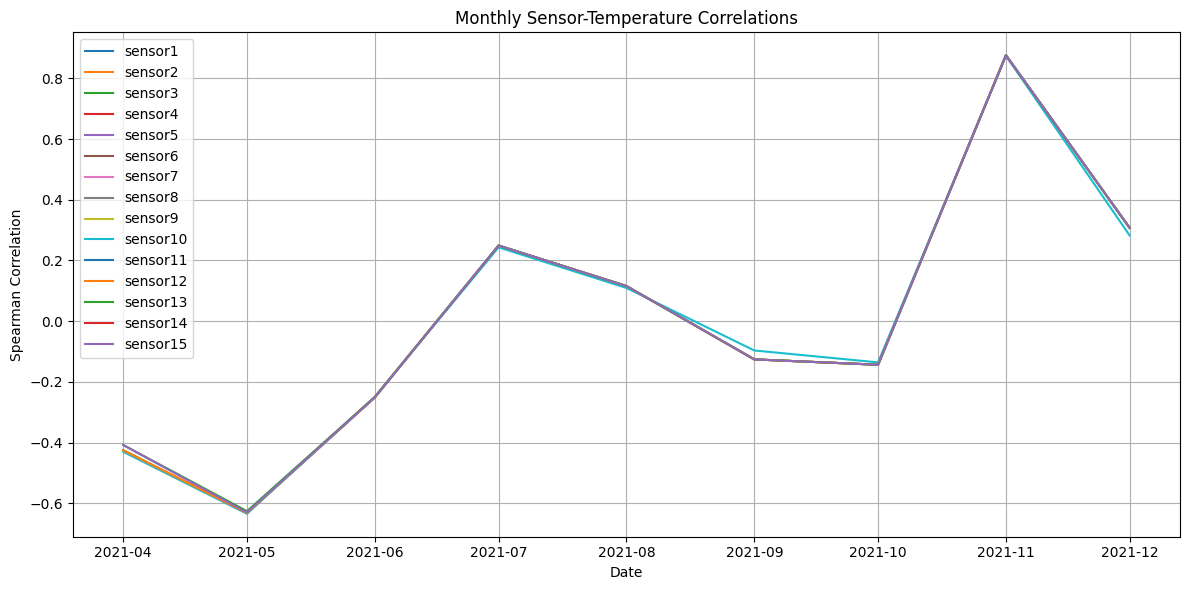

In [94]:
# Create the year_month column
df_energy_outside_temperature['year_month'] = df_energy_outside_temperature['date'].dt.to_period('M')

def calculate_monthly_correlation(dataframe, sensor_column):
    return dataframe.groupby('year_month').apply(
        lambda x: stats.spearmanr(x["outside_temp"], x[sensor_column])[0]
    )

sensor_columns = []
for i in range(1,df_energy_outside_temperature.shape[1]-2):
    val = f'sensor{i}'
    sensor_columns.append(val)

# Dictionary to store results
monthly_correlations = {}

for sensor in sensor_columns:
    # Skip sensors with all NaN values
    if df_energy_outside_temperature[sensor].isna().all():
        # print(f"Skipping {sensor} as it contains all NaN values.")
        continue
    
    monthly_correlations[sensor] = calculate_monthly_correlation(df_energy_outside_temperature, sensor)

# Convert results to a dataframe
result_df = pd.DataFrame(monthly_correlations)

# Reset the index to make year_month a column
result_df = result_df.reset_index()
result_df['date'] = result_df['year_month'].dt.to_timestamp()

plt.figure(figsize=(12, 6))
for sensor in sensor_columns:
    if sensor in result_df.columns:
        plt.plot(result_df['date'], result_df[sensor], label=sensor)

plt.title('Monthly Sensor-Temperature Correlations')
plt.xlabel('Date')
plt.ylabel('Spearman Correlation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [95]:
result_df = result_df.fillna(0)  ## Missing is set to 0

In [96]:
result_df

,year_month,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,date
0,2021-01,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,2021-01-01
1,2021-02,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,2021-02-01
2,2021-03,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,2021-03-01
3,2021-04,-0.443538,0.0,-0.425447,0.0,0.0,-0.425447,0.0,0.0,-0.425447,-0.430490,0.0,-0.425447,-0.408079,0.0,-0.408079,2021-04-01
4,2021-05,0.000000,0.0,-0.632020,0.0,0.0,-0.632020,0.0,0.0,-0.632020,-0.634761,0.0,-0.632020,-0.626175,0.0,-0.630333,2021-05-01
5,2021-06,0.000000,0.0,-0.251168,0.0,0.0,-0.251168,0.0,0.0,-0.251168,-0.249388,0.0,-0.249638,-0.249638,0.0,-0.251168,2021-06-01
6,2021-07,0.000000,0.0,0.249194,0.0,0.0,0.249194,0.0,0.0,0.249194,0.243361,0.0,0.249194,0.249194,0.0,0.249194,2021-07-01
7,2021-08,0.000000,0.0,0.115726,0.0,0.0,0.115726,0.0,0.0,0.115726,0.109451,0.0,0.115726,0.115726,0.0,0.115726,2021-08-01
8,2021-09,0.000000,0.0,-0.125932,0.0,0.0,-0.125932,0.0,0.0,-0.125932,-0.096577,0.0,-0.125932,-0.125932,0.0,-0.125932,2021-09-01
9,2021-10,0.000000,0.0,-0.143606,0.0,0.0,-0.143606,0.0,0.0,-0.143606,-0.135813,0.0,-0.143606,-0.143606,0.0,-0.143606,2021-10-01


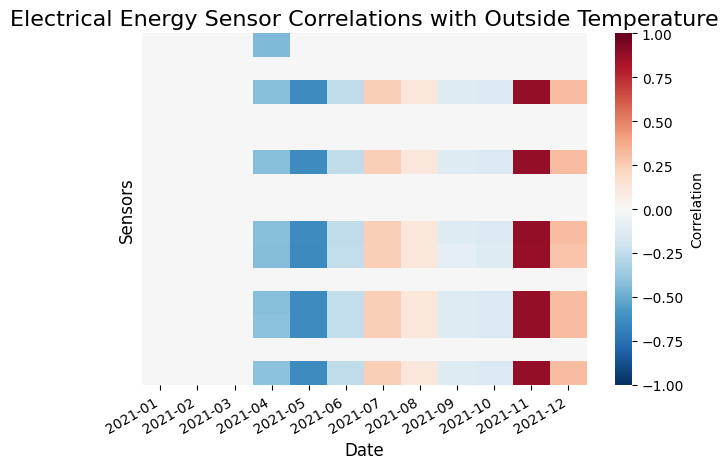

In [97]:
# Create the heatmap
sns.heatmap(result_df[sensor_columns].T, 
            cmap='RdBu_r',
            center=0,
            vmin=-1,
            vmax=1,
            cbar_kws={'label': 'Correlation'},
            xticklabels=result_df['date'].dt.strftime('%Y-%m'),
            # yticklabels=['Sensor 1', 'Sensor 2', 'Sensor 3', 'Sensor 4', 'Sensor 5', 'Sensor 6']
            yticklabels=[]
            )

# Customize the plot
plt.title('Electrical Energy Sensor Correlations with Outside Temperature', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sensors', fontsize=12)

# Rotate and align the tick labels so they look better
plt.gcf().autofmt_xdate()

# Use tight layout to ensure all elements fit in the figure
plt.tight_layout()

In [ ]:
df = result_df

In [ ]:
result_df

In [ ]:
# energyAnalysis_WeatherSensitivity

In [ ]:
# df.to_csv('energyAnalysis_WeatherSensitivity.csv', index=True)

In [106]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import pickle
from tqdm import tqdm
import rdflib
from rdflib import Graph
from rdflib.namespace import BRICK
import warnings
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

class EnergyUsage:
    def __init__(self, db, g):
        self.db = db
        self.g = g
        self.energy_sensor_data = []
        self.daily_median_energy_sensor_data = []
        print(self.daily_median_energy_sensor_data)
        # self.sensor_columns = []

    def get_electrical_meters(self, meter_type, sensor_type):
        # Define the SPARQL query with meter_type and sensor_type as variables
        query = f"""
            SELECT ?meter ?sensor ?stream_id ?phase_count ?phases ?unit ?power_complexity ?power_flow
            WHERE {{
            ?sensor rdf:type brick:{sensor_type} .
            ?meter rdf:type brick:{meter_type} .
            ?sensor brick:isPointOf ?meter .
            ?sensor senaps:stream_id ?stream_id .
            OPTIONAL {{ ?sensor brick:electricalPhaseCount [ brick:value ?phase_count ] . }}
            OPTIONAL {{ ?sensor brick:electricalPhases [ brick:value ?phases ] . }}
            OPTIONAL {{ ?sensor brick:hasUnit [ brick:value ?unit ] . }}
            OPTIONAL {{ ?sensor brick:powerComplexity [ brick:value ?power_complexity ] . }}
            OPTIONAL {{ ?sensor brick:powerFlow [ brick:value ?power_flow ] . }}
        }}
        ORDER BY ?meter
        """
        
        # Run the query
        results = self.g.query(query)

        # Prepare the data for the DataFrame
        data = []
        for row in results:
            data.append({
                'Meter': str(row['meter']),
                'Sensor': str(row['sensor']),
                'Stream ID': str(row['stream_id']),
                'Phase Count': str(row['phase_count']) if row['phase_count'] else None,
                'Phases': str(row['phases']) if row['phases'] else None,
                'Unit': str(row['unit']) if row['unit'] else None,
                'Power Complexity': str(row['power_complexity']) if row['power_complexity'] else None,
                'Power Flow': str(row['power_flow']) if row['power_flow'] else None
            })

        # Create a DataFrame from the results
        df_meters = pd.DataFrame(data)
        
        return df_meters
    
    def get_outside_temperature(self):
        # Define the SPARQL query to retrieve Outside_Air_Temperature_Sensor
        query_outside_airtemp = """
        SELECT ?sensor ?stream_id 
        WHERE {
            ?sensor rdf:type brick:Outside_Air_Temperature_Sensor .
            ?sensor brick:isPointOf   ?loc .
            ?loc a brick:Weather_Station .
            ?sensor senaps:stream_id ?stream_id .
        }
        ORDER BY ?stream_id
        """
        # Run the query
        results_outside_airtemp = g.query(query_outside_airtemp)
        # Prepare the data for the DataFrame
        data_outside_airtemp = []
        for row in results_outside_airtemp:
            data_outside_airtemp.append({
                'Sensor': str(row['sensor']),
                'Stream ID': str(row['stream_id']),
            })
        # Create a DataFrame from the results
        df_outside_airtemp = pd.DataFrame(data_outside_airtemp)
        return df_outside_airtemp
    
    def load_sensors_from_db(self, df):
        """
        Load the sensor data corresponding to the stream IDs in the DataFrame using the DBManager instance.
        """
        # Ensure that both StreamID columns are strings
        df['Stream ID'] = df['Stream ID'].astype(str).str.lower()
    
        # Function to retrieve sensor data from the database for a given stream ID
        def get_sensor_data_for_stream(stream_id):
            if pd.isna(stream_id):  # Handle missing stream_id
                print(f"Stream ID is missing: {stream_id}")
                return None
            
            # Fetch the sensor data from the database using the provided stream ID
            try:
                sensor_df = self.db.get_stream(stream_id).dropna()
                if not sensor_df.empty:
                    return {
                        'streamid': stream_id,
                        'sensor_type': sensor_df['label'].iloc[0],  # Assuming label is the sensor type
                        'timestamps': pd.to_datetime(sensor_df['time']),
                        'values': sensor_df['value']
                    }
                else:
                    print(f"No data found for Stream ID: {stream_id}")
                    return None
            except Exception as e:
                print(f"Error loading data for Stream ID {stream_id}: {e}")
                return None
    
        # Apply the function to load sensor data for each stream ID
        df['sensor_data'] = df['Stream ID'].apply(get_sensor_data_for_stream)
    
        return df
    
    def rolling_spearman(self,x, y, window):
        corr_values = []
        for i in range(len(x) - window + 1):
            # Compute Spearman's Rank Correlation for each rolling window
            corr, _ = spearmanr(x[i:i + window], y[i:i + window])
            # print(corr)
            corr_values.append(corr)
        # Pad with NaNs at the start to match the length of original data
        return np.concatenate((np.full(window - 1, np.nan), corr_values))
    
    def daily_median_temp(self):
        df_outside_airtemp = self.get_outside_temperature()
        df_outside_air_temp_data = self.load_sensors_from_db(df_outside_airtemp)
        df_outside_temperature = pd.DataFrame(df_outside_air_temp_data['sensor_data'][0])
        df_outside_temperature['timestamps'] = pd.to_datetime(df_outside_temperature['timestamps'])
        daily_median_outside_temperature = df_outside_temperature.groupby(df_outside_temperature['timestamps'].dt.date)['values'].median().reset_index()
        daily_median_outside_temperature.columns = ['date', 'outside_temp']
        # self.daily_median_outside_temperature = daily_median_outside_temperature
        return daily_median_outside_temperature  
    

    def daily_median_energy(self,meter_type, sensor_type):
        daily_median_outside_temperature = self.daily_median_temp()
        df_energy_meters = self.get_electrical_meters(meter_type, sensor_type)
        df_energy_meters_data = self.load_sensors_from_db(df_energy_meters)
        # energy_sensor_data = []
        for i in range(df_energy_meters_data.shape[0]):
            self.energy_sensor_data.append(pd.DataFrame(df_energy_meters_data['sensor_data'][i]))
            
        # daily_median_energy_sensor_data = []
        for i in range(len(self.energy_sensor_data)):
            df_energy_sensor_data_1 = self.energy_sensor_data[i]
            df_energy_sensor_data_1['timestamps'] = pd.to_datetime(df_energy_sensor_data_1['timestamps'])
            daily_median_energy_sensor_data_1 = df_energy_sensor_data_1.groupby(df_energy_sensor_data_1['timestamps'].dt.date)['values'].median().reset_index()
            daily_median_energy_sensor_data_1.columns = ['date', 'energy_sensor_val']
            self.daily_median_energy_sensor_data.append(daily_median_energy_sensor_data_1)
        df_energy_temperature = self.daily_median_energy_sensor_data[0].copy()
        df_energy_temperature.columns = ['date', 'sensor1']
        # Loop through the remaining dataframes and merge them
        for i, df in enumerate(self.daily_median_energy_sensor_data[1:], start=2):
            df.columns = ['date', f'sensor{i}']
            df_energy_temperature = pd.merge(df_energy_temperature, df, on='date', how='outer')
        df_energy_outside_temperature = df_energy_temperature.merge(daily_median_outside_temperature, on='date', how='inner')
        df_energy_outside_temperature['date'] = pd.to_datetime(df_energy_outside_temperature['date'])
        return df_energy_outside_temperature 




    def create_year_month_df(self,meter_type, sensor_type):
        # Create the year_month column
        df_energy_outside_temperature= self.daily_median_energy(meter_type, sensor_type)
        df_energy_outside_temperature['year_month'] = df_energy_outside_temperature['date'].dt.to_period('M')

        def calculate_monthly_correlation(dataframe, sensor_column):
            return dataframe.groupby('year_month').apply(
                lambda x: stats.spearmanr(x["outside_temp"], x[sensor_column])[0]
            )

        sensor_columns = []
        for i in range(1,df_energy_outside_temperature.shape[1]-2):
            val = f'sensor{i}'
            sensor_columns.append(val)

        # Dictionary to store results
        monthly_correlations = {}

        for sensor in sensor_columns:
            # Skip sensors with all NaN values
            if df_energy_outside_temperature[sensor].isna().all():
                # print(f"Skipping {sensor} as it contains all NaN values.")
                continue
            
            monthly_correlations[sensor] = calculate_monthly_correlation(df_energy_outside_temperature, sensor)

        # Convert results to a dataframe
        result_df = pd.DataFrame(monthly_correlations)

        # Reset the index to make year_month a column
        result_df = result_df.reset_index()
        result_df['date'] = result_df['year_month'].dt.to_timestamp()
        
        return result_df

    def plot_line(self,meter_type, sensor_type):
        result_df = self.create_year_month_df(meter_type, sensor_type)
        sensor_columns = []
        for i in range(1,df_energy_outside_temperature.shape[1]-2):
            val = f'sensor{i}'
            sensor_columns.append(val)
        plt.figure(figsize=(12, 6))
        for sensor in sensor_columns:
            if sensor in result_df.columns:
                plt.plot(result_df['date'], result_df[sensor], label=sensor)

        plt.title('Monthly Sensor-Temperature Correlations')
        plt.xlabel('Date')
        plt.ylabel('Spearman Correlation')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
    def plot_heatmap(self,meter_type, sensor_type):
        result_df = self.create_year_month_df(meter_type, sensor_type)
        result_df = result_df.fillna(0)  ## Missing is set to 0
        sensor_columns = []
        for i in range(1,df_energy_outside_temperature.shape[1]-2):
            val = f'sensor{i}'
            sensor_columns.append(val)
        # Create the heatmap
        sns.heatmap(result_df[sensor_columns].T, 
                    cmap='RdBu_r',
                    center=0,
                    vmin=-1,
                    vmax=1,
                    cbar_kws={'label': 'Correlation'},
                    xticklabels=result_df['date'].dt.strftime('%Y-%m'),
                    # yticklabels=['Sensor 1', 'Sensor 2', 'Sensor 3', 'Sensor 4', 'Sensor 5', 'Sensor 6']
                    yticklabels=[]
                    )

        # Customize the plot
        plt.title('Electrical Energy Sensor Correlations with Outside Temperature', fontsize=16)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Sensors', fontsize=12)

        # Rotate and align the tick labels so they look better
        plt.gcf().autofmt_xdate()

        # Use tight layout to ensure all elements fit in the figure
        plt.tight_layout()
            

[]


/tmp/ipykernel_13620/3865326429.py:183: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  lambda x: stats.spearmanr(x["outside_temp"], x[sensor_column])[0]
/tmp/ipykernel_13620/3865326429.py:183: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  lambda x: stats.spearmanr(x["outside_temp"], x[sensor_column])[0]
/tmp/ipykernel_13620/3865326429.py:183: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  lambda x: stats.spearmanr(x["outside_temp"], x[sensor_column])[0]
/tmp/ipykernel_13620/3865326429.py:183: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  lambda x: stats.spearmanr(x["outside_temp"], x[sensor_column])[0]
/tmp/ipykernel_13620/3865326429.py:183: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  lambda x: stats.spearmanr(x["outside_temp"], x[sensor_co

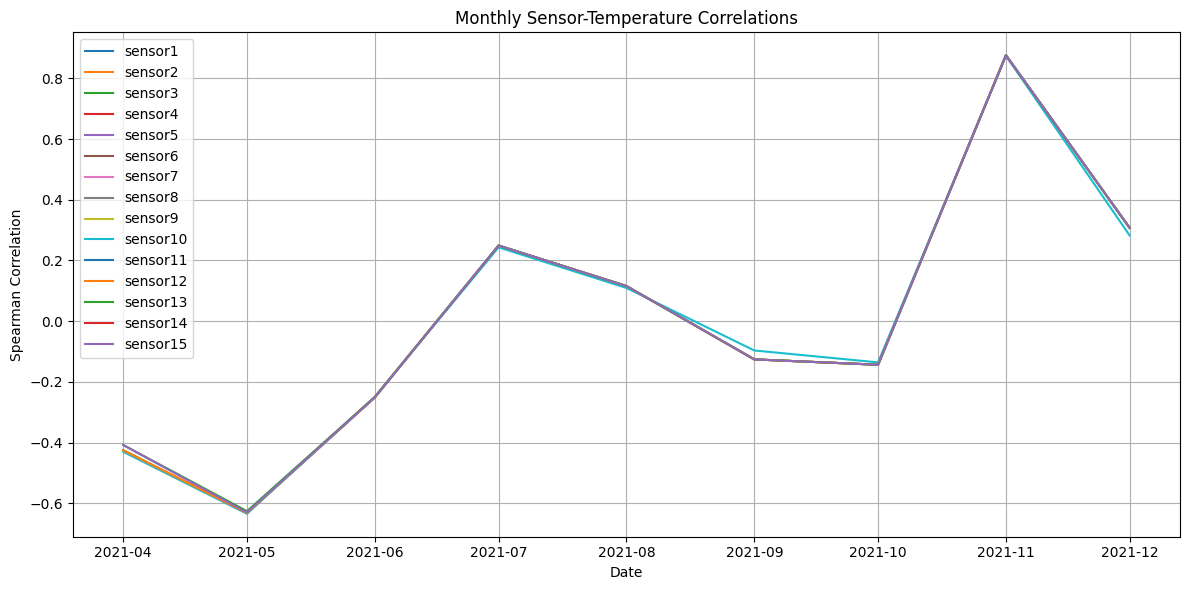

/tmp/ipykernel_13620/3865326429.py:183: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  lambda x: stats.spearmanr(x["outside_temp"], x[sensor_column])[0]
/tmp/ipykernel_13620/3865326429.py:183: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  lambda x: stats.spearmanr(x["outside_temp"], x[sensor_column])[0]
/tmp/ipykernel_13620/3865326429.py:183: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  lambda x: stats.spearmanr(x["outside_temp"], x[sensor_column])[0]
/tmp/ipykernel_13620/3865326429.py:183: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  lambda x: stats.spearmanr(x["outside_temp"], x[sensor_column])[0]
/tmp/ipykernel_13620/3865326429.py:183: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  lambda x: stats.spearmanr(x["outside_temp"], x[sensor_co

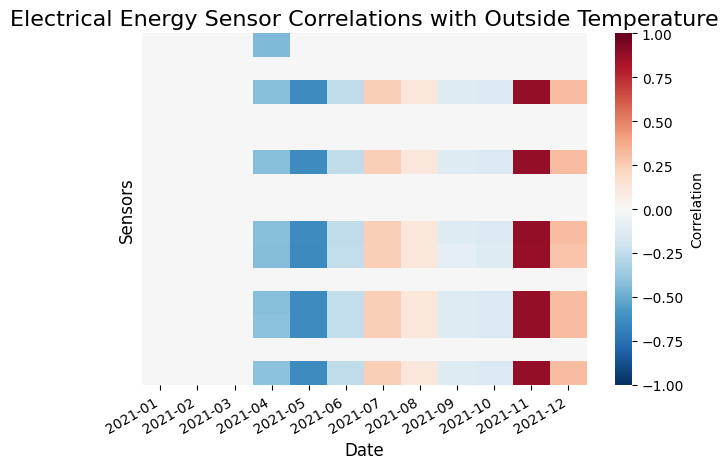

In [107]:
from dbmanager import DBManager

filename_ttl='datasets/bts_site_b_train/Site_B.ttl'

g = Graph().parse(filename_ttl)

data_zip_path = 'datasets/bts_site_b_train/train.zip'
# print(data_zip_path)
mapping_csv_path = 'datasets/bts_site_b_train/mapper_TrainOnly.csv'
db = DBManager(data_zip_path, mapping_csv_path)

EU = EnergyUsage(db, g)

# Call the get_electrical_meters method with appropriate arguments
meter_type = 'Electrical_Meter'  # Example meter type
sensor_type = 'Electrical_Energy_Sensor'  # Example sensor type

# Get the DataFrame
# df_electrical_meters = EU.get_electrical_meters(meter_type, sensor_type)
# load_df = EU.load_sensors_from_db(df_electrical_meters)
# daily_energy = EU.daily_median_energy(meter_type, sensor_type)
# print(daily_energy)
# daily_temp = EU.daily_median_temp()
df_year_month = EU.create_year_month_df(meter_type, sensor_type)
line = EU.plot_line(meter_type, sensor_type)
heat = EU.plot_heatmap(meter_type, sensor_type)
# line

# Assuming you have already initialized 'db' and 'g' properly



In [108]:
line

In [ ]:
heat